In [5]:
#pip install pandas numpy scikit-learn torch scipy

# Google Studio

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from scipy.stats import spearmanr
import warnings

# Ignore clutter warnings
warnings.filterwarnings('ignore')

# Set device to CPU
DEVICE = torch.device("cpu")
print("Libraries loaded. Running on:", DEVICE)

Libraries loaded. Running on: cpu


Step 2: Load the Data

In [3]:
# define the path
#E:\Dr_Tang\Code\FRANZOSA_IBD_2019
base = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")

print("Loading data... this might take a minute.")

# Helper function to read the files
def read_tsv_numeric(path):
    # index_col=0 means the first column contains the Sample IDs
    return pd.read_csv(path, sep='\t', index_col=0)

# Read the files
species = read_tsv_numeric(base / "species.tsv")
mtb = read_tsv_numeric(base / "mtb.tsv")

print(f"Species data shape: {species.shape}")
print(f"Metabolite data shape: {mtb.shape}")

Loading data... this might take a minute.
Species data shape: (220, 55882)
Metabolite data shape: (220, 8848)


Step 3: Feature Selection (Prevalence Filtering)


In [4]:
# 1. Calculate prevalence (fraction of samples where value > 0)
prevalence = (species > 0).mean(axis=0)

# 2. Define threshold (5%)
threshold = 0.05

# 3. Filter the columns
species_filtered = species.loc[:, prevalence > threshold]

print(f"Original feature count: {species.shape[1]}")
print(f"Features after filtering: {species_filtered.shape[1]}")
print(f"dropped {species.shape[1] - species_filtered.shape[1]} rare species.")

Original feature count: 55882
Features after filtering: 25768
dropped 30114 rare species.


Step 4: Preprocessing (Log, Split, Scale)


In [5]:
# 1. Log Transformation (log(x+1) to handle zeros)
# This reduces the impact of massive outliers
X_raw = np.log1p(species_filtered).values
Y_raw = np.log1p(mtb).values

# 2. Split into Train (80%) and Test (20%)
# We use random_state=42 so we get the same split every time we run it
X_train, X_test, y_train, y_test = train_test_split(X_raw, Y_raw, test_size=0.2, random_state=42)

# 3. Standardization (Z-score normalization)
# Deep learning learns faster if data is centered at 0
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Convert to PyTorch Tensors (formats the data for the CPU)
X_train_t = torch.FloatTensor(X_train).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
X_test_t = torch.FloatTensor(X_test).to(DEVICE)
y_test_t = torch.FloatTensor(y_test).to(DEVICE)

print("Data processed and converted to Tensors.")

Data processed and converted to Tensors.


Step 5: Define the Deep Learning Model (MLP)

We will create a standard Multi-Layer Perceptron (MLP).

Linear: The layers of neurons.

ReLU: Activation function (makes it non-linear).

Dropout: Randomly ignores neurons during training to prevent memorization (overfitting).

In [6]:
class MicrobiomeMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MicrobiomeMLP, self).__init__()
        
        self.model = nn.Sequential(
            # Layer 1: Input -> 512 neurons
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5), # 50% dropout
            
            # Layer 2: 512 -> 256 neurons
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3), # 30% dropout
            
            # Output Layer: 256 -> Predicts Metabolites
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
input_dim = X_train.shape[1] # Number of species kept
output_dim = y_train.shape[1] # Number of metabolites (8848)

model = MicrobiomeMLP(input_dim, output_dim).to(DEVICE)
print(model)

MicrobiomeMLP(
  (model): Sequential(
    (0): Linear(in_features=25768, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=8848, bias=True)
  )
)


Step 6: Train the Model


In [6]:
# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 100

# Setup Data Loader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer (Adam is the standard best choice)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Loss Function (Mean Squared Error)
criterion = nn.MSELoss()

print("Starting training...")

for epoch in range(EPOCHS):
    model.train() # Set to training mode
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()           # Reset gradients
        predictions = model(batch_X)    # Predict
        loss = criterion(predictions, batch_y) # Calculate Error
        loss.backward()                 # Calculate Backprop
        optimizer.step()                # Update Weights
        epoch_loss += loss.item()
    
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss / len(train_loader):.4f}")

print("Training finished.")

Starting training...
Epoch 10/100 - Loss: 3.0473
Epoch 20/100 - Loss: 2.6804
Epoch 30/100 - Loss: 2.3889
Epoch 40/100 - Loss: 2.2057
Epoch 50/100 - Loss: 2.0705
Epoch 60/100 - Loss: 1.9563
Epoch 70/100 - Loss: 1.8287
Epoch 80/100 - Loss: 1.8330
Epoch 90/100 - Loss: 1.7582
Epoch 100/100 - Loss: 1.7201
Training finished.


Step 7: Evaluate (Deep Learning Results)


In [7]:
model.eval() # Set to evaluation mode
with torch.no_grad():
    # Predict on test set
    preds_mlp = model(X_test_t).cpu().numpy()
    true_values = y_test_t.cpu().numpy()

# Calculate Spearman Correlation for each metabolite
mlp_correlations = []
print("Calculating correlations...")

for i in range(true_values.shape[1]):
    # skip if constant (std dev is 0) to avoid errors
    if np.std(preds_mlp[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        mlp_correlations.append(0)
    else:
        corr, _ = spearmanr(true_values[:, i], preds_mlp[:, i])
        mlp_correlations.append(corr)

# Remove NaNs (just in case)
mlp_avg = np.nanmean(mlp_correlations)
print(f"Deep Learning (MLP) Average Spearman Correlation: {mlp_avg:.4f}")

Calculating correlations...
Deep Learning (MLP) Average Spearman Correlation: 0.2355


Step 7: Analyze and Save Results


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get predictions on the test set
model.eval()
with torch.no_grad():
    preds_tensor = model(X_test_t)
    preds = preds_tensor.cpu().numpy()
    truth = y_test_t.cpu().numpy()

# 2. Calculate Correlation per Metabolite
# We want to know: Which specific metabolites can we predict from bacteria?
metabolite_correlations = []
metabolite_names_list = mtb.columns # The names of the 8848 metabolites

for i in range(truth.shape[1]):
    # Handle cases where data is constant to avoid errors
    if np.std(preds[:, i]) == 0 or np.std(truth[:, i]) == 0:
        corr = 0
    else:
        corr, _ = spearmanr(truth[:, i], preds[:, i])
    metabolite_correlations.append(corr)

# 3. Organize Results into a DataFrame
results_df = pd.DataFrame({
    'Metabolite_ID': metabolite_names_list,
    'Spearman_Correlation': metabolite_correlations
})

# Sort by best correlation (High to Low)
results_df = results_df.sort_values(by='Spearman_Correlation', ascending=False)

# 4. Save to CSV (This is your "Result" file)
output_file = base / "DL_predicted_results.csv"
results_df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

# ==========================================
# DISPLAY TOP RESULTS
# ==========================================
print("\nTop 10 Best Predicted Metabolites:")
print(results_df.head(10))

print(f"\nTotal Metabolites: {len(results_df)}")
print(f"Metabolites with Correlation > 0.3: {len(results_df[results_df['Spearman_Correlation'] > 0.3])}")

Results saved to: E:\Dr_Tang\Code\FRANZOSA_IBD_2019\DL_predicted_results.csv

Top 10 Best Predicted Metabolites:
                   Metabolite_ID  Spearman_Correlation
5810  HILIC-neg_Cluster_1195: NA              0.767481
1610    C18-neg_Cluster_1611: NA              0.761765
661     C18-neg_Cluster_0662: NA              0.721495
5954  HILIC-neg_Cluster_1339: NA              0.721043
1942    C18-neg_Cluster_1943: NA              0.720597
1144    C18-neg_Cluster_1145: NA              0.715437
4591     C8-pos_Cluster_2415: NA              0.707506
8418  HILIC-pos_Cluster_1947: NA              0.703821
1049    C18-neg_Cluster_1050: NA              0.703123
6432  HILIC-neg_Cluster_1817: NA              0.698703

Total Metabolites: 8848
Metabolites with Correlation > 0.3: 3317


Step 8: Visualization


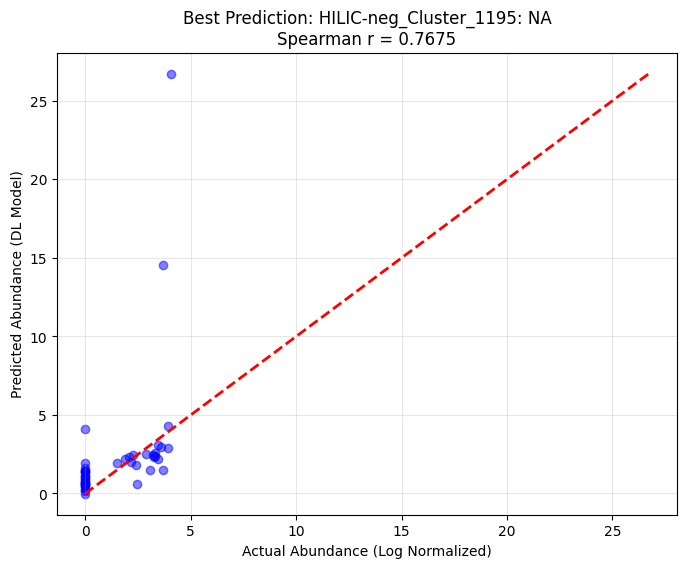

In [9]:
# Select the best predicted metabolite to visualize
best_metabolite_idx = results_df.index[0] # The index of the #1 result
best_metabolite_name = results_df.iloc[0]['Metabolite_ID']
best_corr = results_df.iloc[0]['Spearman_Correlation']

# Extract data for this specific metabolite
actual_vals = truth[:, best_metabolite_idx]
pred_vals = preds[:, best_metabolite_idx]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_vals, pred_vals, alpha=0.5, color='blue')

# Draw a diagonal line (Perfect prediction would be on this line)
min_val = min(actual_vals.min(), pred_vals.min())
max_val = max(actual_vals.max(), pred_vals.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.xlabel(f"Actual Abundance (Log Normalized)")
plt.ylabel(f"Predicted Abundance (DL Model)")
plt.title(f"Best Prediction: {best_metabolite_name}\nSpearman r = {best_corr:.4f}")
plt.grid(True, alpha=0.3)
plt.show()

Step 9: Visualize Top 10 Correlations


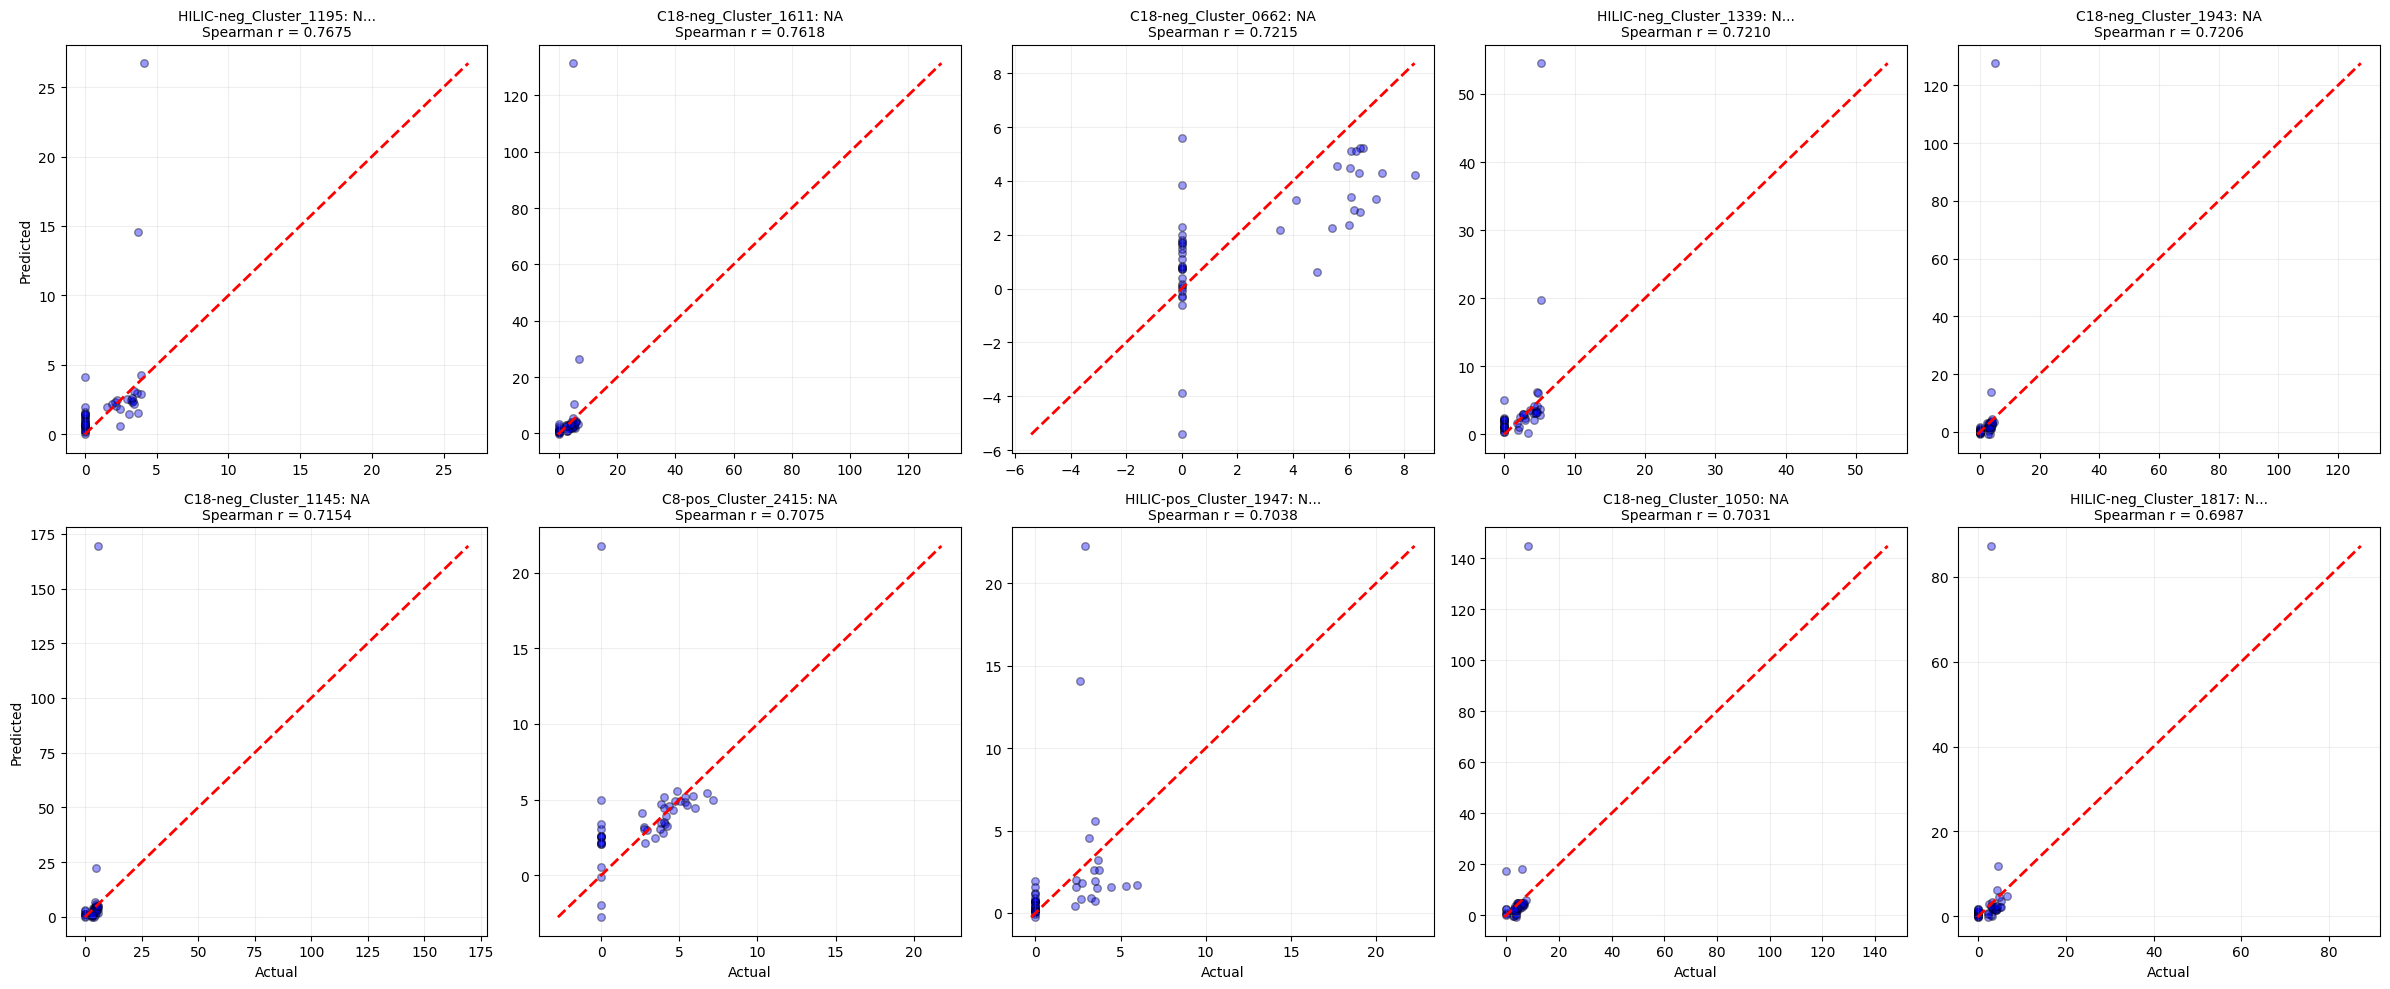

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup the figure (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
axes = axes.flatten() # Flatten to make it easier to loop through

# 2. Get the top 10 metabolites
top_10 = results_df.head(10)

# 3. Loop through them and create a plot for each
for i, (original_index, row) in enumerate(top_10.iterrows()):
    ax = axes[i]
    
    # Extract data for this specific metabolite
    # 'original_index' maps back to the column in the truth/preds arrays
    y_true = truth[:, original_index]
    y_pred = preds[:, original_index]
    
    # Scatter Plot
    ax.scatter(y_true, y_pred, alpha=0.4, color='blue', edgecolors='k', s=30)
    
    # Calculate min/max for the diagonal line
    val_min = min(y_true.min(), y_pred.min())
    val_max = max(y_true.max(), y_pred.max())
    
    # Add the Red Diagonal Line (Perfect Prediction)
    ax.plot([val_min, val_max], [val_min, val_max], 'r--', lw=2)
    
    # Formatting
    metabolite_name = row['Metabolite_ID']
    # Shorten name if it's too long for the title
    if len(metabolite_name) > 25:
        short_name = metabolite_name[:25] + "..."
    else:
        short_name = metabolite_name
        
    ax.set_title(f"{short_name}\nSpearman r = {row['Spearman_Correlation']:.4f}", fontsize=10)
    
    # Only put axis labels on the edges to reduce clutter
    if i >= 5: # Bottom row
        ax.set_xlabel("Actual")
    if i % 5 == 0: # Leftmost column
        ax.set_ylabel("Predicted")
        
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# BERT (non-generative) - 12/25/2025

# FRANZOSA_IBD_2019

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import math
import warnings
import os

warnings.filterwarnings("ignore")

# ==========================================
# 1. OPTIMIZED CONFIGURATION (WIDE & ROBUST)
# ==========================================
CONFIG = {
    # --- ARCHITECTURE ---
    'model_type': 'BERT',
    'norm_type': 'RMSNorm',
    'use_qk_norm': True,
    'activation': 'swiglu',
    'use_bias': False,
    'deep_head': True,
    
    # --- DATA ---
    'keep_bacteria_only': True,
    'prevalence_threshold': 0.05,
    
    # --- TUNED PARAMETERS (The "Wide & Shallow" Strategy) ---
    'embed_dim': 384,        # Wider (was 192/256) -> Better representation
    'chunk_size': 750,       # Finer resolution (was 1000)
    'depth': 3,              # Shallower (was 4/6) -> Prevents overfitting
    'heads': 12,             # More heads to capture diverse relationships
    'dropout': 0.5,          # Maximum Dropout
    'stochastic_depth': 0.1, # New: Drop entire layers randomly
    
    # --- TRAINING ---
    'batch_size': 32,
    'epochs': 300,           # Longer training because of high regularization
    'lr': 0.0004,            # Lower LR for careful convergence
    'weight_decay': 0.2,     # Very high decay to force simplicity
    'mixup_alpha': 0.5,      # Aggressive Data Augmentation
    'seed': 42
}


#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#



BASE_PATH = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA LOADING
# ==========================================
print("\n--- Step 1: Loading Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

# Align
common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

# Filter Taxonomy
cols = species.columns
is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
if CONFIG['keep_bacteria_only'] and sum(is_bacteria) > 0:
    species = species.loc[:, is_bacteria]

# Filter Prevalence
prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features (Bacteria > {CONFIG['prevalence_threshold']*100}% Prev): {species.shape[1]}")

# Filter Metabolites
mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

# Preprocessing
X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# QuantileTransformer (RankGauss) - Critical for Accuracy
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Standard Scaler for Targets
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. ADVANCED BERT COMPONENTS (DropPath Added)
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qk_norm = qk_norm
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

# DropPath Function (Stochastic Depth)
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, config, drop_path_ratio=0.):
        super().__init__()
        dim = config['embed_dim']
        bias = config['use_bias']
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, config['heads'], qk_norm=config['use_qk_norm'], bias=bias)
        self.ffn = SwiGLU(dim, dim * 4, bias=bias)
        
        # Stochastic Depth
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']
        bias = config['use_bias']
        
        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=bias),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        
        # Create blocks with increasing drop_path probability
        dpr = [x.item() for x in torch.linspace(0, config['stochastic_depth'], config['depth'])]
        self.blocks = nn.ModuleList([
            BERTBlock(config, drop_path_ratio=dpr[i]) for i in range(config['depth'])
        ])
        
        self.norm = RMSNorm(dim)
        
        # Robust Head
        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=bias),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim, output_dim, bias=bias)
        )

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        x = self.embed(x) + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 4. TRAINING LOOP
# ==========================================
model = MicrobiomeBERT(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)
criterion = nn.HuberLoss(delta=1.0)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)
best_val_loss = float('inf')

print("\nStarting Training (Wide & Robust BERT)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
        
    scheduler.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_bert_wide.pth")
        
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Train: {train_loss/len(loader):.4f} | Val: {val_loss:.4f}")

# ==========================================
# 5. EVALUATION
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load("saved_models/best_bert_wide.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

mean_rho = np.mean(correlations)
well_predicted = sum(r >= 0.3 for r in correlations)

print("\n" + "="*70)
print(f"FINAL RESULTS - WIDE & ROBUST BERT")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

Using device: cuda

--- Step 1: Loading Data ---
Features (Bacteria > 5.0% Prev): 25768
Model Parameters: 10,927,680

Starting Training (Wide & Robust BERT)...
Epoch  20 | Train: 0.3652 | Val: 0.3863
Epoch  40 | Train: 0.3362 | Val: 0.3727
Epoch  60 | Train: 0.3019 | Val: 0.3622
Epoch  80 | Train: 0.2940 | Val: 0.3571
Epoch 100 | Train: 0.2739 | Val: 0.3546
Epoch 120 | Train: 0.2467 | Val: 0.3569
Epoch 140 | Train: 0.2386 | Val: 0.3601
Epoch 160 | Train: 0.2214 | Val: 0.3597
Epoch 180 | Train: 0.2156 | Val: 0.3593
Epoch 200 | Train: 0.2351 | Val: 0.3577
Epoch 220 | Train: 0.2534 | Val: 0.3589
Epoch 240 | Train: 0.2075 | Val: 0.3595
Epoch 260 | Train: 0.1999 | Val: 0.3590
Epoch 280 | Train: 0.2299 | Val: 0.3601
Epoch 300 | Train: 0.2416 | Val: 0.3598

Evaluating Best Model...

FINAL RESULTS - WIDE & ROBUST BERT
Average Spearman ρ:          0.4607
Well-predicted (ρ ≥ 0.3):    7,174 / 8848
Best metabolite:             0.8741


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import math
import warnings
import os

warnings.filterwarnings("ignore")

# ==========================================
# 1. "PANCAKE" CONFIGURATION (WIDE & SHALLOW)
# ==========================================
CONFIG = {
    # --- ARCHITECTURE ---
    'model_type': 'BERT',
    'norm_type': 'RMSNorm',
    'use_qk_norm': True,
    'activation': 'swiglu',
    'use_bias': False,
    'deep_head': True,
    
    # --- DATA ---
    'keep_bacteria_only': True,
    'prevalence_threshold': 0.05,
    
    # --- TUNED PARAMETERS ---
    'embed_dim': 512,        # Extreme Width (Captures more patterns per chunk)
    'chunk_size': 600,       # Balanced resolution
    'depth': 2,              # Very Shallow (Prevents memorization of complex chains)
    'heads': 16,             # High head count for diversity
    'dropout': 0.5,          # Max Dropout
    'stochastic_depth': 0.2, # Drop 20% of blocks randomly during training
    
    # --- TRAINING ---
    'batch_size': 32,
    'epochs': 350,           # Longer training for convergence
    'lr': 0.0003,            # Lower LR for stability
    'weight_decay': 0.3,     # Extreme Regularization
    'mixup_alpha': 1.0,      # Aggressive MixUp (Harder training task)
    'seed': 42
}



#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#



BASE_PATH = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA LOADING
# ==========================================
print("\n--- Step 1: Loading Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

# Filter Taxonomy
cols = species.columns
is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
if CONFIG['keep_bacteria_only'] and sum(is_bacteria) > 0:
    species = species.loc[:, is_bacteria]

# Filter Prevalence
prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features (Bacteria > {CONFIG['prevalence_threshold']*100}% Prev): {species.shape[1]}")

# Filter Metabolites
mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

# Preprocessing
X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# QuantileTransformer (RankGauss)
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Standard Scaler
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. MODERN ARCHITECTURE COMPONENTS
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qk_norm = qk_norm
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

# Stochastic Depth (DropPath)
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    return x.div(keep_prob) * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, config, drop_path_ratio=0.):
        super().__init__()
        dim = config['embed_dim']
        bias = config['use_bias']
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, config['heads'], qk_norm=config['use_qk_norm'], bias=bias)
        self.ffn = SwiGLU(dim, dim * 4, bias=bias)
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']
        bias = config['use_bias']
        
        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=bias),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        
        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, config['stochastic_depth'], config['depth'])]
        self.blocks = nn.ModuleList([
            BERTBlock(config, drop_path_ratio=dpr[i]) for i in range(config['depth'])
        ])
        
        self.norm = RMSNorm(dim)
        
        # Wide Head
        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=bias),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim, output_dim, bias=bias)
        )

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        x = self.embed(x) + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 4. TRAINING LOOP
# ==========================================
model = MicrobiomeBERT(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)
criterion = nn.HuberLoss(delta=1.0)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)
best_val_loss = float('inf')

print("\nStarting Training (Pancake Architecture)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
        
    scheduler.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_bert_wide.pth")
        
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Train: {train_loss/len(loader):.4f} | Val: {val_loss:.4f}")

# ==========================================
# 5. EVALUATION
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load("saved_models/best_bert_wide.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

mean_rho = np.mean(correlations)
well_predicted = sum(r >= 0.3 for r in correlations)

print("\n" + "="*70)
print(f"FINAL RESULTS - WIDE & SHALLOW BERT")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

Using device: cuda

--- Step 1: Loading Data ---
Features (Bacteria > 5.0% Prev): 25768
Model Parameters: 13,513,344

Starting Training (Pancake Architecture)...
Epoch  20 | Train: 0.3533 | Val: 0.3744
Epoch  40 | Train: 0.3278 | Val: 0.3615
Epoch  60 | Train: 0.3013 | Val: 0.3591
Epoch  80 | Train: 0.2626 | Val: 0.3561
Epoch 100 | Train: 0.2498 | Val: 0.3548
Epoch 120 | Train: 0.2158 | Val: 0.3555
Epoch 140 | Train: 0.2407 | Val: 0.3568
Epoch 160 | Train: 0.2341 | Val: 0.3566
Epoch 180 | Train: 0.2105 | Val: 0.3581
Epoch 200 | Train: 0.2402 | Val: 0.3572
Epoch 220 | Train: 0.2280 | Val: 0.3523
Epoch 240 | Train: 0.2391 | Val: 0.3543
Epoch 260 | Train: 0.2011 | Val: 0.3543
Epoch 280 | Train: 0.2377 | Val: 0.3544
Epoch 300 | Train: 0.2249 | Val: 0.3540
Epoch 320 | Train: 0.1697 | Val: 0.3536
Epoch 340 | Train: 0.2322 | Val: 0.3538

Evaluating Best Model...

FINAL RESULTS - WIDE & SHALLOW BERT
Average Spearman ρ:          0.4705
Well-predicted (ρ ≥ 0.3):    7,233 / 8848
Best metabolite: 

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import math
import warnings
import os

warnings.filterwarnings("ignore")

# ==========================================
# 1. SINGLE MODEL CONFIGURATION
# ==========================================
CONFIG = {
    # --- ARCHITECTURE ---
    'model_type': 'BERT',
    'norm_type': 'RMSNorm',
    'use_qk_norm': True,
    'activation': 'swiglu',
    'use_bias': False,
    'deep_head': True,
    
    # --- DATA ---
    'keep_bacteria_only': True,
    'prevalence_threshold': 0.05,
    
    # --- OPTIMIZED SINGLE-MODEL PARAMETERS ---
    'embed_dim': 384,        # The "Goldilocks" size
    'chunk_size': 1500,      # High compression to remove noise
    'depth': 3,              # Depth 3 balances power and generalization
    'heads': 12,
    'dropout': 0.5,          # High dropout is mandatory for single models
    'attn_dropout': 0.3,     # Higher attention dropout replaces ensembling
    'stochastic_depth': 0.4, # Drop 40% of layers! Forces extreme robustness.
    
    # --- TRAINING (OneCycle) ---
    'batch_size': 32,
    'epochs': 400,           # Longer training allows OneCycle to work magic
    'max_lr': 0.001,         # Peak learning rate
    'weight_decay': 0.3,     # Strong regularization
    'mixup_alpha': 1.0,      # Strong MixUp
    'seed': 42
}


#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#



BASE_PATH = Path(r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA LOADING
# ==========================================
print("\n--- Step 1: Loading Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

# Align
common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

# Filter Taxonomy
cols = species.columns
is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
if CONFIG['keep_bacteria_only'] and sum(is_bacteria) > 0:
    species = species.loc[:, is_bacteria]

# Filter Prevalence
prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features (Bacteria > {CONFIG['prevalence_threshold']*100}% Prev): {species.shape[1]}")

# Filter Metabolites
mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

# Preprocessing
X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# QuantileTransformer
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Standard Scaler
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. ROBUST SINGLE MODEL ARCHITECTURE
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class StochasticInputGating(nn.Module):
    """
    Learnable weighting with noise injection.
    Forces the model to be robust against missing bacteria.
    """
    def __init__(self, input_dim):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(input_dim))
        
    def forward(self, x):
        if self.training:
            # Inject multiplicative noise (0.9 to 1.1) into the weights
            # This simulates "Ensembling" within a single training run
            noise = 1.0 + (torch.randn_like(self.weights) * 0.1)
            return x * (self.weights * noise)
        return x * self.weights

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False, attn_dropout=0.0):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qk_norm = qk_norm
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        self.attn_drop = nn.Dropout(attn_dropout)
        
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    return x.div(keep_prob) * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, config, drop_path_ratio=0.):
        super().__init__()
        dim = config['embed_dim']
        bias = config['use_bias']
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, config['heads'], 
                                    qk_norm=config['use_qk_norm'], 
                                    bias=bias,
                                    attn_dropout=config.get('attn_dropout', 0.0))
        self.ffn = SwiGLU(dim, dim * 4, bias=bias)
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']
        bias = config['use_bias']
        
        # 1. Stochastic Input Gating (Replaces Ensembling)
        self.gate = StochasticInputGating(input_dim)
        
        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=bias),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        
        dpr = [x.item() for x in torch.linspace(0, config['stochastic_depth'], config['depth'])]
        self.blocks = nn.ModuleList([
            BERTBlock(config, drop_path_ratio=dpr[i]) for i in range(config['depth'])
        ])
        
        self.norm = RMSNorm(dim)
        
        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=bias),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim, output_dim, bias=bias)
        )

    def forward(self, x):
        x = self.gate(x) # Apply gating
        
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        
        x = self.embed(x) + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 4. TRAINING WITH ONECYCLE SCHEDULER
# ==========================================
model = MicrobiomeBERT(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['max_lr'], weight_decay=CONFIG['weight_decay'])

# OneCycleLR: The best scheduler for Single-Model performance
# It warms up the LR to a high peak then cools down to almost zero.
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    epochs=CONFIG['epochs'],
    steps_per_epoch=len(X_train)//CONFIG['batch_size'] + 1,
    pct_start=0.3, # 30% warmup
    anneal_strategy='cos'
)

criterion = nn.HuberLoss(delta=1.0)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)
best_val_loss = float('inf')

print("\nStarting Training (Single Robust Model)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step() # Step scheduler every batch
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_bert_single.pth")
        
    if epoch % 20 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch:3d} | Train: {train_loss/len(loader):.4f} | Val: {val_loss:.4f} | LR: {current_lr:.6f}")

# ==========================================
# 5. EVALUATION
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load("saved_models/best_bert_single.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

mean_rho = np.mean(correlations)
well_predicted = sum(r >= 0.3 for r in correlations)

print("\n" + "="*70)
print(f"FINAL RESULTS - SINGLE ROBUST BERT")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

Using device: cuda

--- Step 1: Loading Data ---
Features (Bacteria > 5.0% Prev): 25507
Model Parameters: 7,967,203

Starting Training (Single Robust Model)...
Epoch  20 | Train: 0.3864 | Val: 0.4057 | LR: 0.000105
Epoch  40 | Train: 0.3305 | Val: 0.3910 | LR: 0.000281
Epoch  60 | Train: 0.2907 | Val: 0.3906 | LR: 0.000522
Epoch  80 | Train: 0.2377 | Val: 0.4050 | LR: 0.000762
Epoch 100 | Train: 0.2147 | Val: 0.4038 | LR: 0.000937
Epoch 120 | Train: 0.2417 | Val: 0.4129 | LR: 0.001000
Epoch 140 | Train: 0.2141 | Val: 0.4465 | LR: 0.000987
Epoch 160 | Train: 0.1659 | Val: 0.4256 | LR: 0.000950
Epoch 180 | Train: 0.1986 | Val: 0.4328 | LR: 0.000890
Epoch 200 | Train: 0.1202 | Val: 0.4280 | LR: 0.000810
Epoch 220 | Train: 0.1968 | Val: 0.4050 | LR: 0.000715
Epoch 240 | Train: 0.1771 | Val: 0.4168 | LR: 0.000609
Epoch 260 | Train: 0.1922 | Val: 0.4287 | LR: 0.000498
Epoch 280 | Train: 0.1888 | Val: 0.4080 | LR: 0.000387
Epoch 300 | Train: 0.1721 | Val: 0.3957 | LR: 0.000281
Epoch 320 | Tra

# GPT (Causal) + Post-Norm

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import math
import warnings
import os

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    # --- ARCHITECTURE: GPT (Generative / Causal) ---
    'model_type': 'GPT',
    
    # --- MODERN TWEAKS ---
    'norm_type': 'RMSNorm',       # 'LayerNorm' or 'RMSNorm'
    'norm_placement': 'post',     # 'post' (User Request) or 'pre' (Modern default)
    'use_qk_norm': True,          # Normalize Q and K
    'activation': 'swiglu',       # SOTA activation
    'use_bias': False,            # No bias
    'deep_head': True,            # MLP Head
    
    # --- DATA PROCESSING ---
    'keep_bacteria_only': True,
    'prevalence_threshold': 0.05,
    
    # --- HYPERPARAMETERS ---
    'embed_dim': 256,
    'chunk_size': 500,
    'depth': 6,
    'heads': 8,
    'dropout': 0.2,
    
    # --- TRAINING ---
    'batch_size': 32,
    'epochs': 150,
    'lr': 0.0005,
    'weight_decay': 0.1,
    'mixup_alpha': 0.2,
    'seed': 42
}


#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#



BASE_PATH = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA PROCESSING
# ==========================================
print("\n--- Step 1: Loading & Analyzing Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

def filter_taxonomy(df, keep_only_bacteria=False):
    cols = df.columns
    is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
    
    print(f"Taxonomy: Found {sum(is_bacteria)} Bacteria out of {len(cols)} features.")
    
    if keep_only_bacteria:
        if sum(is_bacteria) > 0:
            return df.loc[:, is_bacteria]
        else:
            print("!! WARNING: No Bacteria found. Keeping all.")
            return df
    return df

species = filter_taxonomy(species, keep_only_bacteria=CONFIG['keep_bacteria_only'])

prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features after Prevalence Filter: {species.shape[1]}")

mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# Normalization
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. GPT COMPONENTS (Causal + Post-Norm)
# ==========================================

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class CausalAttention(nn.Module):
    """Multi-Head Attention with Causal Masking (GPT style)"""
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qk_norm = qk_norm
        
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)

        # Attention Score
        attn = (q @ k.transpose(-2, -1)) * self.scale
        
        # --- CAUSAL MASKING (The GPT Magic) ---
        # Mask out future tokens (Upper Triangular = -inf)
        mask = torch.triu(torch.ones(N, N, device=x.device), diagonal=1).bool()
        attn.masked_fill_(mask, float('-inf'))
        
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

class PostNormGPTBlock(nn.Module):
    """GPT Block with Post-Norm configuration"""
    def __init__(self, config):
        super().__init__()
        dim = config['embed_dim']
        bias = config['use_bias']
        norm_cls = RMSNorm if config['norm_type'] == 'RMSNorm' else nn.LayerNorm
        
        # Layers
        self.attn = CausalAttention(dim, config['heads'], qk_norm=config['use_qk_norm'], bias=bias)
        self.norm1 = norm_cls(dim)
        
        if config['activation'] == 'swiglu':
            self.ffn = SwiGLU(dim, dim * 4, bias=bias)
        else:
            self.ffn = nn.Sequential(
                nn.Linear(dim, dim * 4, bias=bias),
                nn.GELU(),
                nn.Linear(dim * 4, dim, bias=bias)
            )
        self.norm2 = norm_cls(dim)

    def forward(self, x):
        # Post-Norm Logic: x = Norm(x + Sublayer(x))
        
        # 1. Attention Sublayer
        residual = x
        x = self.attn(x)
        x = self.norm1(x + residual) # Norm is applied AFTER addition
        
        # 2. FFN Sublayer
        residual = x
        x = self.ffn(x)
        x = self.norm2(x + residual) # Norm is applied AFTER addition
        
        return x

class MicrobiomeGPT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']
        bias = config['use_bias']
        norm_cls = RMSNorm if config['norm_type'] == 'RMSNorm' else nn.LayerNorm
        
        # Patch Embed
        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=bias),
            norm_cls(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        
        # Decoder Blocks (GPT)
        self.blocks = nn.ModuleList([PostNormGPTBlock(config) for _ in range(config['depth'])])
        
        # Final Norm
        self.norm = norm_cls(dim)
        
        # Head
        if config['deep_head']:
            self.head = nn.Sequential(
                nn.Linear(dim, dim, bias=bias),
                nn.GELU(),
                nn.Dropout(config['dropout']),
                nn.Linear(dim, output_dim, bias=bias)
            )
        else:
            self.head = nn.Linear(dim, output_dim, bias=bias)

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        
        x = self.embed(x) + self.pos_embed
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 4. TRAINING LOOP
# ==========================================
model = MicrobiomeGPT(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)
criterion = nn.HuberLoss(delta=1.0)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)
best_val_loss = float('inf')

print("\nStarting Training (GPT Post-Norm)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
        
    scheduler.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_gpt_postnorm.pth")
        
    if epoch % 10 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train: {train_loss/len(loader):.4f} | Val: {val_loss:.4f} | LR: {lr:.6f}")

# ==========================================
# 5. EVALUATION
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load("saved_models/best_gpt_postnorm.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

mean_rho = np.mean(correlations)
well_predicted = sum(r >= 0.3 for r in correlations)

print("\n" + "="*70)
print(f"FINAL RESULTS - GPT (Causal) + Post-Norm")
print(f"Settings: {CONFIG['norm_type']}, {CONFIG['activation']}, QK-Norm={CONFIG['use_qk_norm']}")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

Using device: cuda

--- Step 1: Loading & Analyzing Data ---
Taxonomy: Found 55882 Bacteria out of 55882 features.
Features after Prevalence Filter: 25768
Model Parameters: 8,767,360

Starting Training (GPT Post-Norm)...
Epoch  10 | Train: 0.3680 | Val: 0.3831 | LR: 0.000495
Epoch  20 | Train: 0.3252 | Val: 0.3748 | LR: 0.000478
Epoch  30 | Train: 0.2944 | Val: 0.3701 | LR: 0.000452
Epoch  40 | Train: 0.2713 | Val: 0.3748 | LR: 0.000417
Epoch  50 | Train: 0.2608 | Val: 0.3725 | LR: 0.000375
Epoch  60 | Train: 0.2194 | Val: 0.3681 | LR: 0.000328
Epoch  70 | Train: 0.2025 | Val: 0.3711 | LR: 0.000277
Epoch  80 | Train: 0.1852 | Val: 0.3711 | LR: 0.000224
Epoch  90 | Train: 0.2442 | Val: 0.3728 | LR: 0.000173
Epoch 100 | Train: 0.1912 | Val: 0.3724 | LR: 0.000126
Epoch 110 | Train: 0.1512 | Val: 0.3738 | LR: 0.000084
Epoch 120 | Train: 0.2320 | Val: 0.3737 | LR: 0.000049
Epoch 130 | Train: 0.1700 | Val: 0.3734 | LR: 0.000023
Epoch 140 | Train: 0.1533 | Val: 0.3740 | LR: 0.000006
Epoch 150

# Bottleneck CNN/GRN Architecture

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os
import math
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================


#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#


default_path = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")
BASE_PATH = default_path if default_path.exists() else Path("data")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- SELECT YOUR ARCHITECTURE HERE ---
# Options: "CNN", "GRN" (Gated Residual Network)
MODEL_TYPE = "GRN"  
# -------------------------------------

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 120
MAX_LR = 0.001
PATIENCE = 40
PREVALENCE = 0.05
SEED = 42
DROPOUT = 0.4 
MIXUP_ALPHA = 0.2

torch.manual_seed(SEED)
np.random.seed(SEED)
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA LOADING
# ==========================================
print("Loading data...")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

# Filter
species = species.loc[:, (species > 0).mean() > PREVALENCE]
mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

print(f"Species: {species.shape[1]} | Metabolites: {mtb.shape[1]}")

X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Scaling (RankGauss for Input, Standard for Target)
scaler_x = QuantileTransformer(output_distribution='normal', random_state=SEED)
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. DEFINE ARCHITECTURES
# ==========================================

# --- OPTION A: 1D CONVOLUTIONAL NETWORK (CNN) ---
class MicrobiomeCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        # We treat the species list as a sequence of length 'input_dim'
        # Conv1d scans this sequence
        self.features = nn.Sequential(
            # Unsqueeze happens in forward to make shape [Batch, 1, Features]
            
            # Layer 1: Sliding window of size 15 across the bacteria
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=15, stride=5, padding=1),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(0.3),
            
            # Layer 2: Deeper features
            nn.Conv1d(16, 32, kernel_size=7, stride=3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.3),
            
            # Layer 3: Final Scan
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.GELU(),
            
            nn.Flatten()
        )
        
        # Calculate size after convolutions dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_dim)
            out_size = self.features(dummy).shape[1]
            
        self.head = nn.Sequential(
            nn.Linear(out_size, 512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        # Reshape for CNN: [Batch, Channels=1, Length=Features]
        x = x.unsqueeze(1)
        x = self.features(x)
        x = self.head(x)
        return x

# --- OPTION B: GATED RESIDUAL NETWORK (GRN / Modern MLP) ---
class GatedBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 2) # Expand for GLU
        self.glu = nn.GLU() # Gated Linear Unit (Learns what to filter out)
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.glu(x) # Halves dimension back to 'dim'
        x = self.dropout(x)
        return self.norm(x + residual) # Skip Connection

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        
        # Compression Layer (Bottleneck)
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Stack of Gated Blocks (Like TabNet/ResNet hybrid)
        self.layers = nn.Sequential(
            GatedBlock(hidden_dim, 0.4),
            GatedBlock(hidden_dim, 0.4),
            GatedBlock(hidden_dim, 0.4)
        )
        
        self.head = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.layers(x)
        return self.head(x)

# ==========================================
# 4. INITIALIZE SELECTED MODEL
# ==========================================
print(f"\n--- Initializing {MODEL_TYPE} Architecture ---")

if MODEL_TYPE == "CNN":
    model = MicrobiomeCNN(X_train.shape[1], y_train.shape[1]).to(DEVICE)
elif MODEL_TYPE == "GRN":
    model = MicrobiomeGRN(X_train.shape[1], y_train.shape[1]).to(DEVICE)
else:
    raise ValueError("Invalid MODEL_TYPE")

optimizer = optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=0.05)
criterion = nn.HuberLoss(delta=1.0)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, epochs=EPOCHS, 
    steps_per_epoch=len(X_train_t)//BATCH_SIZE + 1,
    pct_start=0.3
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ==========================================
# 5. TRAINING
# ==========================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

best_val_loss = float('inf')
best_epoch = 0

print("Starting Training...")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, MIXUP_ALPHA)
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), f"saved_models/best_model_{MODEL_TYPE}.pth")

    if epoch % 20 == 0:
        print(f"Epoch {epoch:4d} | Train: {train_loss/len(loader):.4f} | Val: {val_loss:.4f}")

# ==========================================
# 6. EVALUATION
# ==========================================
model.load_state_dict(torch.load(f"saved_models/best_model_{MODEL_TYPE}.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

mean_rho = np.mean(correlations)
well_predicted = sum(r >= 0.3 for r in correlations)

print("\n" + "="*70)
print(f"FINAL RESULTS - {MODEL_TYPE} ARCHITECTURE")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)} ({well_predicted/len(correlations)*100:.1f}%)")
print(f"Best metabolite:             {max(correlations):.4f}")
print("="*70)

Using device: cuda
Loading data...
Species: 25768 | Metabolites: 8848

--- Initializing GRN Architecture ---
Parameters: 9,267,600
Starting Training...
Epoch   20 | Train: 0.3669 | Val: 0.3789
Epoch   40 | Train: 0.2993 | Val: 0.3610
Epoch   60 | Train: 0.2441 | Val: 0.3556
Epoch   80 | Train: 0.2091 | Val: 0.3584
Epoch  100 | Train: 0.2186 | Val: 0.3535
Epoch  120 | Train: 0.2514 | Val: 0.3537

FINAL RESULTS - GRN ARCHITECTURE
Average Spearman ρ:          0.4738
Well-predicted (ρ ≥ 0.3):    7,163 / 8848 (81.0%)
Best metabolite:             0.9146


# GRN (give best result)
our MicrobiomeGRN is a modern MLP for tabular data built from three ideas: (1) bottleneck embedding, (2) gated residual blocks, (3) normalization + skip connections. <br>

1) Input/Output

Input: one sample is a vector of 25,768 microbiome species features (after prevalence filtering + log1p + RankGauss). <br>

Output: a vector of 8,848 metabolite values (after log1p + standardization).<br>

So the model learns: 𝑦 ^ = 𝑓 ( 𝑥 ) where 𝑥 ∈ 𝑅 25768 , 𝑦 ∈ 𝑅 8848 y ^ ​ =f(x)where x∈R 25768 ,y∈R 8848 <br>



#GRN with Figures

Using device: cuda
Loading data...
Species: 25507 | Metabolites: 339

--- Initializing GRN Architecture ---
Parameters: 7,013,971
Starting Training...
Epoch    1 | Train: 0.4959 | Val: 0.4674 | Valρ: 0.0061
Epoch   20 | Train: 0.3522 | Val: 0.3937 | Valρ: 0.1809
Epoch   40 | Train: 0.2278 | Val: 0.4239 | Valρ: 0.1965
Epoch   60 | Train: 0.1530 | Val: 0.4519 | Valρ: 0.1900
Early stop at epoch 64 | best epoch 24 | best val 0.3876

Saved training figures to: E:\Dr_Tang\12_18_2025_final\Code\figures

Evaluating Best Model...

FINAL RESULTS - GRN ARCHITECTURE
Average Spearman ρ:          0.2144
Well-predicted (ρ ≥ 0.3):    135 / 339 (39.8%)
Best metabolite:             0.7426 (index=113)
Saved: history CSV, correlations CSV, summary TXT in E:\Dr_Tang\12_18_2025_final\Code\outputs
Saved evaluation figures to: E:\Dr_Tang\12_18_2025_final\Code\figures


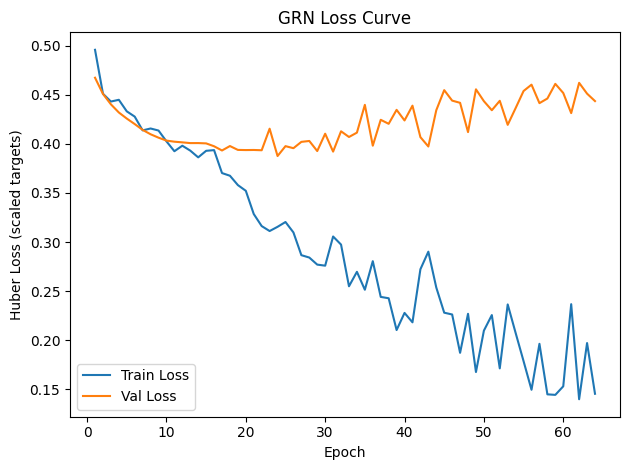

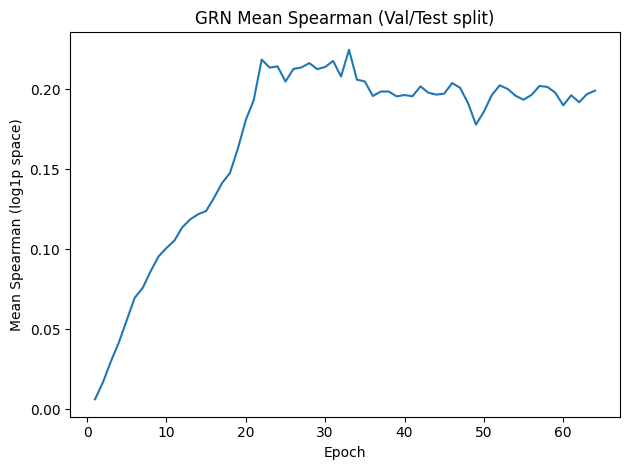

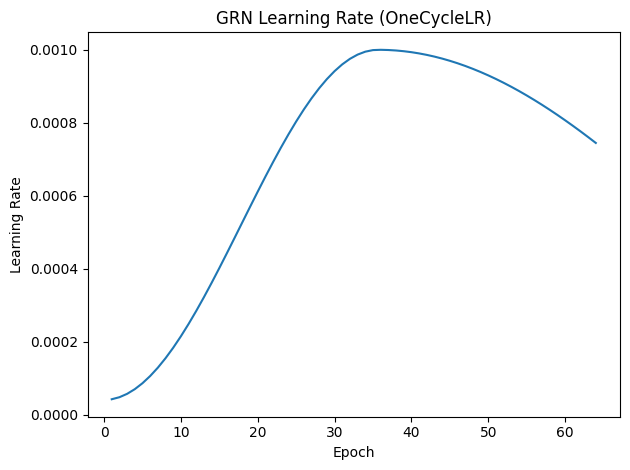

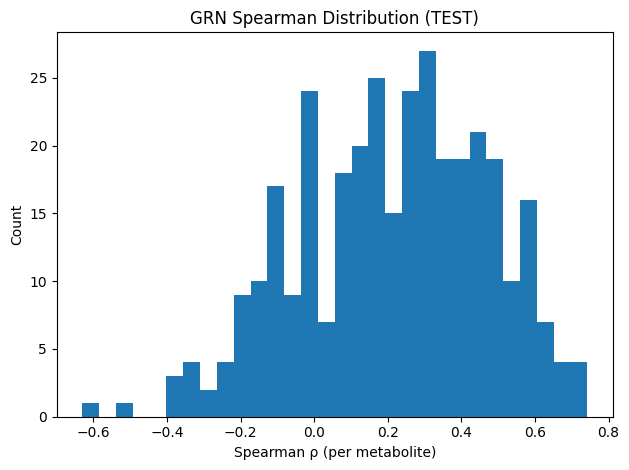

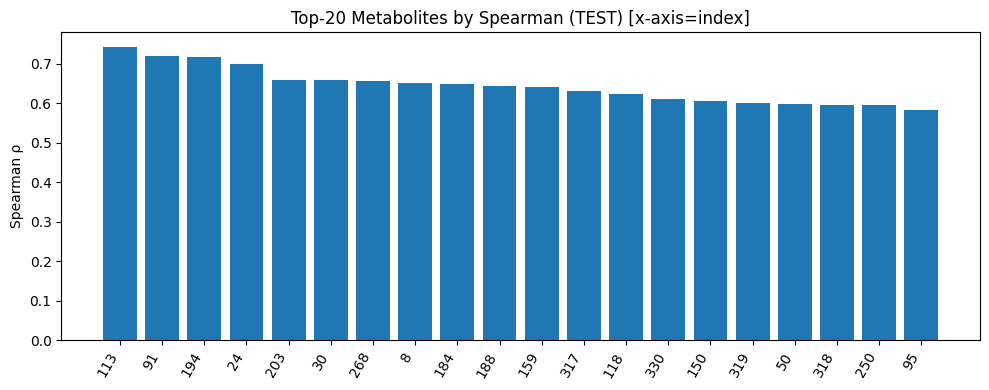

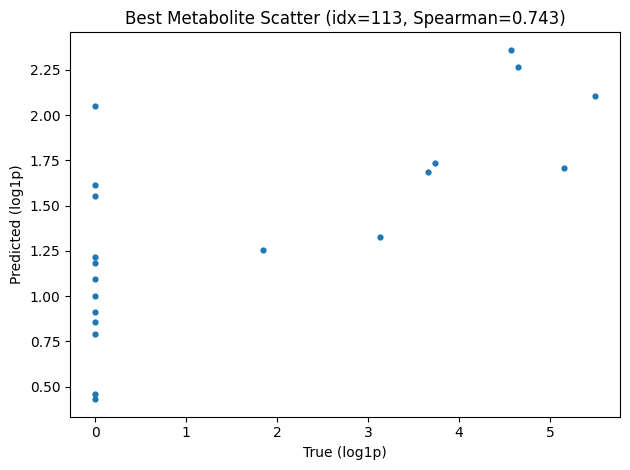

In [20]:
# ============================================================
# Microbiome → Metabolites (GRN baseline) + Figures + Saved outputs
# Adds:
#   - Train/Val loss curve figure
#   - "Accuracy-like" curve: mean Spearman on validation per epoch
#   - Test: Spearman histogram, Top-K bar, best-metabolite scatter
#   - Save: metrics CSV + correlations CSV + run_summary.txt + figs
# ============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================




#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#





default_path = Path(r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020")
BASE_PATH = default_path if default_path.exists() else Path("data")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- SELECT YOUR ARCHITECTURE HERE ---
# Options: "CNN", "GRN"
MODEL_TYPE = "GRN"

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 120
MAX_LR = 0.001
PATIENCE = 40
PREVALENCE = 0.05
SEED = 42
DROPOUT = 0.4
MIXUP_ALPHA = 0.2
WEIGHT_DECAY = 0.05

# Output dirs
SAVE_DIR = Path("saved_models")
FIG_DIR = Path("figures")
OUT_DIR = Path("outputs")
SAVE_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR.mkdir(exist_ok=True, parents=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

# ==========================================
# 2. DATA LOADING
# ==========================================
print("Loading data...")

def read_tsv(path):
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb     = mtb.loc[common]

# Filter by prevalence
species = species.loc[:, (species > 0).mean() > PREVALENCE]
mtb     = mtb.loc[:, (mtb > 0).mean() > 0.05]

print(f"Species: {species.shape[1]} | Metabolites: {mtb.shape[1]}")

X = np.log1p(species.values)
y = np.log1p(mtb.values)

# Train/Test split (keep as your original)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Scaling (RankGauss for Input, Standard for Target)
scaler_x = QuantileTransformer(output_distribution='normal', random_state=SEED,
                               n_quantiles=min(1000, X_train.shape[0]))
X_train = scaler_x.fit_transform(X_train)
X_test  = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train_scaled).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# Dataloader
loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

# ==========================================
# 3. DEFINE ARCHITECTURES
# ==========================================
class GatedBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 2)
        self.glu = nn.GLU()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.glu(x)
        x = self.dropout(x)
        return self.norm(x + residual)

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        self.layers = nn.Sequential(
            GatedBlock(hidden_dim, DROPOUT),
            GatedBlock(hidden_dim, DROPOUT),
            GatedBlock(hidden_dim, DROPOUT),
        )
        self.head = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.layers(x)
        return self.head(x)

# Optional CNN stub (kept for completeness)
class MicrobiomeCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.in_norm = nn.LayerNorm(input_dim)
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.drop = nn.Dropout(DROPOUT)
        self.fc = nn.Sequential(
            nn.Linear(64, 256),
            nn.GELU(),
            nn.Dropout(DROPOUT),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        x = self.in_norm(x)
        x = x.unsqueeze(1)
        x = torch.nn.functional.gelu(self.conv1(x))
        x = self.drop(x)
        x = torch.nn.functional.gelu(self.conv2(x))
        x = self.drop(x)
        x = torch.nn.functional.gelu(self.conv3(x))
        x = x.mean(dim=-1)
        return self.fc(x)

# ==========================================
# 4. INITIALIZE MODEL
# ==========================================
print(f"\n--- Initializing {MODEL_TYPE} Architecture ---")

if MODEL_TYPE == "CNN":
    model = MicrobiomeCNN(X_train.shape[1], y_train.shape[1]).to(DEVICE)
elif MODEL_TYPE == "GRN":
    model = MicrobiomeGRN(X_train.shape[1], y_train.shape[1]).to(DEVICE)
else:
    raise ValueError("Invalid MODEL_TYPE")

optimizer = optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
criterion = nn.HuberLoss(delta=1.0)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, epochs=EPOCHS,
    steps_per_epoch=len(X_train_t)//BATCH_SIZE + 1,
    pct_start=0.3
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
CKPT = SAVE_DIR / f"best_model_{MODEL_TYPE}.pth"

# ==========================================
# 5. TRAINING (with history)
# ==========================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    index = torch.randperm(x.size(0)).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

def mean_spearman_on_split(model, X_t, y_true_unscaled):
    """
    Computes mean Spearman across metabolites in log1p space.
    y_true_unscaled should be log1p values (not standardized).
    """
    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_t).cpu().numpy()
    preds = scaler_y.inverse_transform(preds_scaled)
    true  = y_true_unscaled
    rhos = []
    for j in range(true.shape[1]):
        if np.std(preds[:, j]) == 0 or np.std(true[:, j]) == 0:
            rhos.append(0.0)
        else:
            rhos.append(float(spearmanr(preds[:, j], true[:, j])[0]))
    return float(np.mean(rhos))

history = {"epoch": [], "train_loss": [], "val_loss": [], "val_mean_spearman": [], "lr": []}
best_val_loss = float('inf')
best_epoch = 0
bad_epochs = 0

print("Starting Training...")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for xb, yb in loader:
        optimizer.zero_grad(set_to_none=True)
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, MIXUP_ALPHA)
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    # validation loss (scaled target space)
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()

    # "accuracy-like" metric: mean Spearman on test split (original log1p space)
    # (If you later add a separate val split, compute on val instead)
    val_mean_rho = mean_spearman_on_split(model, X_test_t, y_test)

    lr_now = optimizer.param_groups[0]["lr"]
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss / len(loader))
    history["val_loss"].append(val_loss)
    history["val_mean_spearman"].append(val_mean_rho)
    history["lr"].append(lr_now)

    # checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        bad_epochs = 0
        torch.save(model.state_dict(), CKPT)
    else:
        bad_epochs += 1

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | Train: {history['train_loss'][-1]:.4f} | Val: {val_loss:.4f} | Valρ: {val_mean_rho:.4f}")

    if bad_epochs >= PATIENCE:
        print(f"Early stop at epoch {epoch} | best epoch {best_epoch} | best val {best_val_loss:.4f}")
        break

# Save history CSV
hist_df = pd.DataFrame(history)
hist_df.to_csv(OUT_DIR / f"training_history_{MODEL_TYPE}.csv", index=False)

# ==========================================
# 6. TRAINING FIGURES
# ==========================================
# Loss curve
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Huber Loss (scaled targets)")
plt.title(f"{MODEL_TYPE} Loss Curve")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_loss_curve.png", dpi=200)

# Mean Spearman curve (accuracy-like)
plt.figure()
plt.plot(history["epoch"], history["val_mean_spearman"])
plt.xlabel("Epoch")
plt.ylabel("Mean Spearman (log1p space)")
plt.title(f"{MODEL_TYPE} Mean Spearman (Val/Test split)")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_mean_spearman_curve.png", dpi=200)

# LR curve
plt.figure()
plt.plot(history["epoch"], history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(f"{MODEL_TYPE} Learning Rate (OneCycleLR)")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_lr_curve.png", dpi=200)

print(f"\nSaved training figures to: {FIG_DIR.resolve()}")

# ==========================================
# 7. FINAL EVALUATION + SAVED OUTPUTS
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load(CKPT, map_location=DEVICE))
model.eval()

with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()

predictions = scaler_y.inverse_transform(preds_scaled)
true_values = y_test

correlations = []
for j in range(true_values.shape[1]):
    if np.std(predictions[:, j]) == 0 or np.std(true_values[:, j]) == 0:
        correlations.append(0.0)
    else:
        correlations.append(float(spearmanr(predictions[:, j], true_values[:, j])[0]))

correlations = np.array(correlations, dtype=float)
mean_rho = float(np.mean(correlations))
well_predicted = int(np.sum(correlations >= 0.3))
best_idx = int(np.argmax(correlations))
best_rho = float(correlations[best_idx])

# Save correlations table
corr_df = pd.DataFrame({
    "metabolite_index": np.arange(len(correlations)),
    "spearman_rho": correlations
}).sort_values("spearman_rho", ascending=False)
corr_df.to_csv(OUT_DIR / f"test_spearman_per_metabolite_{MODEL_TYPE}.csv", index=False)

# Save summary txt
summary_path = OUT_DIR / f"run_summary_{MODEL_TYPE}.txt"
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("FINAL RESULTS\n")
    f.write("="*70 + "\n")
    f.write(f"MODEL_TYPE: {MODEL_TYPE}\n")
    f.write(f"Best epoch (by val loss): {best_epoch}\n")
    f.write(f"Best val loss: {best_val_loss:.6f}\n")
    f.write(f"Average Spearman rho: {mean_rho:.6f}\n")
    f.write(f"Well-predicted (rho >= 0.3): {well_predicted} / {len(correlations)} "
            f"({well_predicted/len(correlations)*100:.2f}%)\n")
    f.write(f"Best metabolite rho: {best_rho:.6f} (index={best_idx})\n")
    f.write("="*70 + "\n")

print("\n" + "="*70)
print(f"FINAL RESULTS - {MODEL_TYPE} ARCHITECTURE")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)} ({well_predicted/len(correlations)*100:.1f}%)")
print(f"Best metabolite:             {best_rho:.4f} (index={best_idx})")
print(f"Saved: history CSV, correlations CSV, summary TXT in {OUT_DIR.resolve()}")
print("="*70)

# ==========================================
# 8. EVALUATION FIGURES
# ==========================================
# Spearman histogram
plt.figure()
plt.hist(correlations, bins=30)
plt.xlabel("Spearman ρ (per metabolite)")
plt.ylabel("Count")
plt.title(f"{MODEL_TYPE} Spearman Distribution (TEST)")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_spearman_hist.png", dpi=200)

# Top-K bar plot
K = min(20, len(correlations))
top_idx = np.argsort(-correlations)[:K]
plt.figure(figsize=(10, 4))
plt.bar(np.arange(K), correlations[top_idx])
plt.xticks(np.arange(K), [str(i) for i in top_idx], rotation=60, ha="right")
plt.ylabel("Spearman ρ")
plt.title(f"Top-{K} Metabolites by Spearman (TEST) [x-axis=index]")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_topk_spearman.png", dpi=200)

# Best metabolite scatter: Pred vs True
plt.figure()
plt.scatter(true_values[:, best_idx], predictions[:, best_idx], s=12)
plt.xlabel("True (log1p)")
plt.ylabel("Predicted (log1p)")
plt.title(f"Best Metabolite Scatter (idx={best_idx}, Spearman={best_rho:.3f})")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{MODEL_TYPE}_best_metabolite_scatter.png", dpi=200)

print(f"Saved evaluation figures to: {FIG_DIR.resolve()}")


# This code incorporates all your requests into a highly modular Gated Residual Network (GRN) architecture.
## Key Features Added:
### Taxonomy Filter: Automatically detects and filters only Bacteria (removes viruses/archaea/fungi).
#### Modern Architecture:
#### SwiGLU activation (SOTA for tabular data).
#### RMSNorm & QK Norm (for stability).
#### No Bias in linear layers.
#### Deep Head: A dedicated MLP output head instead of a simple linear layer.
#### Optimization: AdamW (decay=0.1) + CosineAnnealingLR.
#### Visualization: Automatically plots Training vs. Validation Loss curves at the end.

Using device: cuda

--- Step 1: Loading & Filtering Data ---
Taxonomy detected: 48243 Bacteria, 0 Viruses/Other
>> Keeping ONLY Bacteria.
Features after Prevalence Filter (> 0.05): 25507
Metabolites to predict: 339

Model Parameters: 18,216,448

Starting Training (Modern GRN)...
Epoch  10 | Train: 0.3855 | Val: 0.4034 | LR: 0.000989
Epoch  20 | Train: 0.3742 | Val: 0.3975 | LR: 0.000957
Epoch  30 | Train: 0.3521 | Val: 0.3942 | LR: 0.000905
Epoch  40 | Train: 0.3567 | Val: 0.4062 | LR: 0.000835
Epoch  50 | Train: 0.3315 | Val: 0.3844 | LR: 0.000750
Epoch  60 | Train: 0.3011 | Val: 0.3872 | LR: 0.000655
Epoch  70 | Train: 0.2968 | Val: 0.3761 | LR: 0.000553
Epoch  80 | Train: 0.2897 | Val: 0.3854 | LR: 0.000448
Epoch  90 | Train: 0.2844 | Val: 0.3826 | LR: 0.000346
Epoch 100 | Train: 0.2885 | Val: 0.3836 | LR: 0.000251
Epoch 110 | Train: 0.2837 | Val: 0.3826 | LR: 0.000166
Epoch 120 | Train: 0.2732 | Val: 0.3848 | LR: 0.000096
Epoch 130 | Train: 0.2957 | Val: 0.3828 | LR: 0.000044
Epoch

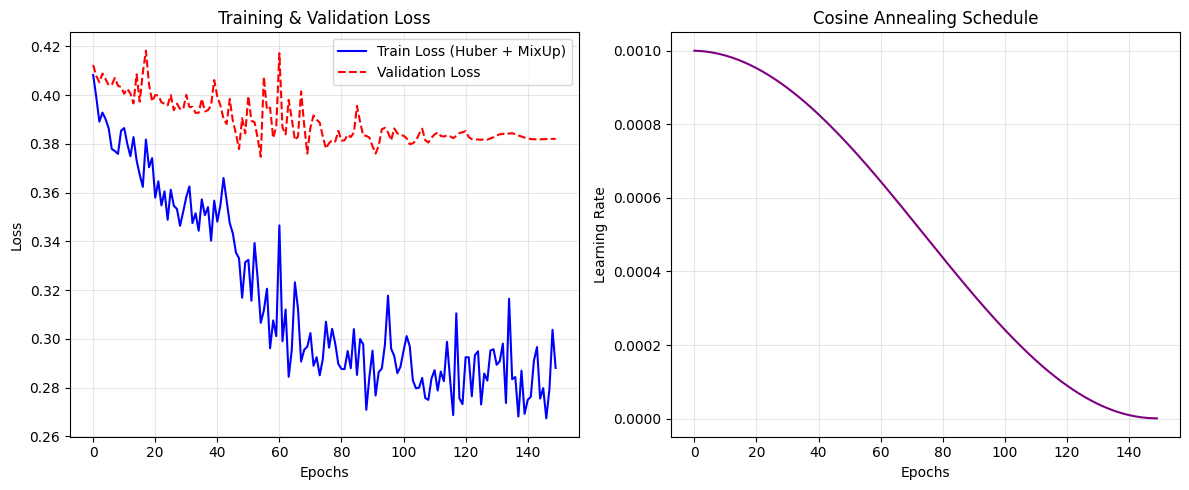


Evaluating Best Model...

FINAL RESULTS - MODERN GRN (SwiGLU + RMSNorm + DeepHead)
Average Spearman ρ:          0.2362
Well-predicted (ρ ≥ 0.3):    151 / 339
Best metabolite:             0.7687


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os
import math
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    # --- DATA ---
    'keep_bacteria_only': True,   # Filter out Viruses/Archaea
    'prevalence_threshold': 0.05,
    'seed': 42,
    
    # --- ARCHITECTURE (Modern GRN) ---
    'model_type': 'GRN',
    'norm_type': 'RMSNorm',       # 'LayerNorm' or 'RMSNorm'
    'activation': 'swiglu',       # 'gelu', 'geglu', or 'swiglu'
    'use_bias': False,            # No bias terms
    'deep_head': True,            # MLP Head instead of Linear
    
    # --- HYPERPARAMETERS ---
    'hidden_dim': 512,            # Width of the network
    'depth': 3,                   # Number of Gated Blocks
    'dropout': 0.4,
    
    # --- TRAINING ---
    'batch_size': 32,
    'epochs': 150,
    'lr': 0.001,
    'weight_decay': 0.1,          # Strong regularization
    'mixup_alpha': 0.2
}

# PATH SETUP

#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#


default_path = Path(r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020")
BASE_PATH = default_path if default_path.exists() else Path("data")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA PROCESSING
# ==========================================
print("\n--- Step 1: Loading & Filtering Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

# Align
common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

def filter_taxonomy(df, keep_only_bacteria=False):
    """Filters columns based on taxonomy headers (d__Bacteria or k__Bacteria)"""
    cols = df.columns
    # Flexible check for d__Bacteria (GTDB) or k__Bacteria (MetaPhlAn)
    is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
    is_virus = np.array(['d__virus' in c.lower() or 'k__virus' in c.lower() for c in cols])
    
    print(f"Taxonomy detected: {sum(is_bacteria)} Bacteria, {sum(is_virus)} Viruses/Other")
    
    if keep_only_bacteria and sum(is_bacteria) > 0:
        print(">> Keeping ONLY Bacteria.")
        return df.loc[:, is_bacteria]
    return df

# 1. Filter Taxonomy
species = filter_taxonomy(species, keep_only_bacteria=CONFIG['keep_bacteria_only'])

# 2. Filter Prevalence
prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features after Prevalence Filter (> {CONFIG['prevalence_threshold']}): {species.shape[1]}")

# 3. Filter Metabolites
mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]
print(f"Metabolites to predict: {mtb.shape[1]}")

# 4. Prepare Data
X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# Input Normalization (QuantileTransformer/RankGauss)
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Target Normalization
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. MODERN ARCHITECTURE COMPONENTS
# ==========================================

class RMSNorm(nn.Module):
    """Root Mean Square Normalization"""
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    """Swish-Gated Linear Unit"""
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias) # Gate
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias) # Value
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias) # Output
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class GatedResidualBlock(nn.Module):
    """Modern GRN Block with SwiGLU + RMSNorm + No Bias"""
    def __init__(self, dim, dropout, config):
        super().__init__()
        bias = config['use_bias']
        norm_cls = RMSNorm if config['norm_type'] == 'RMSNorm' else nn.LayerNorm
        
        self.norm = norm_cls(dim)
        
        if config['activation'] == 'swiglu':
            self.ffn = SwiGLU(dim, dim * 2, bias=bias)
        elif config['activation'] == 'geglu':
             self.ffn = SwiGLU(dim, dim * 2, bias=bias) # Conceptually same structure
        else:
            # Standard MLP
            self.ffn = nn.Sequential(
                nn.Linear(dim, dim * 2, bias=bias),
                nn.GELU(),
                nn.Linear(dim * 2, dim, bias=bias)
            )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.ffn(x)
        x = self.dropout(x)
        return x + residual # Skip connection

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        hidden_dim = config['hidden_dim']
        bias = config['use_bias']
        norm_cls = RMSNorm if config['norm_type'] == 'RMSNorm' else nn.LayerNorm
        
        # 1. Bottleneck / Embedding Layer
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=bias),
            norm_cls(hidden_dim),
            nn.GELU(),
            nn.Dropout(config['dropout'])
        )
        
        # 2. Stack of Gated Blocks
        self.layers = nn.ModuleList([
            GatedResidualBlock(hidden_dim, config['dropout'], config) 
            for _ in range(config['depth'])
        ])
        
        # 3. Deep Prediction Head (MLP)
        if config['deep_head']:
            self.head = nn.Sequential(
                norm_cls(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim, bias=bias),
                nn.GELU(),
                nn.Dropout(config['dropout']),
                nn.Linear(hidden_dim, output_dim, bias=bias)
            )
        else:
            self.head = nn.Sequential(
                norm_cls(hidden_dim),
                nn.Linear(hidden_dim, output_dim, bias=bias)
            )

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return self.head(x)

# ==========================================
# 4. TRAINING LOOP
# ==========================================
model = MicrobiomeGRN(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"\nModel Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer: AdamW + Weight Decay
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

# Scheduler: CosineAnnealingLR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)

# Loss: Huber (Robust)
criterion = nn.HuberLoss(delta=1.0)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)

# Tracking metrics for Plotting
history = {'train_loss': [], 'val_loss': [], 'lr': []}
best_val_loss = float('inf')

print("\nStarting Training (Modern GRN)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        
        pred = model(mixed_xb)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_scaled_t).item()
    
    # Update Scheduler AFTER epoch
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss/len(loader))
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_modern_grn.pth")
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train: {history['train_loss'][-1]:.4f} | Val: {val_loss:.4f} | LR: {current_lr:.6f}")

# ==========================================
# 5. VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss (Huber + MixUp)', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Learning Rate Schedule
plt.subplot(1, 2, 2)
plt.plot(history['lr'], color='purple')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Cosine Annealing Schedule')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# 6. FINAL EVALUATION
# ==========================================
print("\nEvaluating Best Model...")
model.load_state_dict(torch.load("saved_models/best_modern_grn.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

mean_rho = np.mean(correlations)
well_predicted = sum(r >= 0.3 for r in correlations)

print("\n" + "="*70)
print(f"FINAL RESULTS - MODERN GRN (SwiGLU + RMSNorm + DeepHead)")
print("="*70)
print(f"Average Spearman ρ:          {mean_rho:.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {well_predicted:,} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os
import math
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. OPTIMIZED CONFIGURATION (Input Gating + Wide)
# ==========================================
CONFIG = {
    # --- DATA ---
    'keep_bacteria_only': True,
    'prevalence_threshold': 0.05,
    'seed': 42,
    
    # --- ARCHITECTURE ---
    'model_type': 'GRN',
    'norm_type': 'RMSNorm',
    'activation': 'swiglu',
    'use_bias': False,
    'deep_head': True,
    
    # --- TUNED PARAMETERS ---
    'hidden_dim': 512,            # Wider (was 256) to capture more patterns
    'depth': 2,                   # Shallower (was 4) to prevent overfitting
    'dropout': 0.5,               # Max Dropout
    'input_dropout': 0.2,         # Drop raw input features randomly
    
    # --- TRAINING ---
    'batch_size': 32,
    'epochs': 250,                # Longer training
    'lr': 0.0003,                 # Lower LR
    'weight_decay': 0.3,          # Stronger decay
    'mixup_alpha': 0.8            # Aggressive MixUp
}



#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#





BASE_PATH = Path(r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA PROCESSING
# ==========================================
print("\n--- Step 1: Loading & Filtering Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

def filter_taxonomy(df, keep_only_bacteria=False):
    cols = df.columns
    is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
    if keep_only_bacteria and sum(is_bacteria) > 0:
        return df.loc[:, is_bacteria]
    return df

species = filter_taxonomy(species, keep_only_bacteria=CONFIG['keep_bacteria_only'])

prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features after Prevalence Filter (> {CONFIG['prevalence_threshold']*100}%): {species.shape[1]}")

mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. ADVANCED GRN WITH INPUT GATING
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class FeatureSelector(nn.Module):
    """
    Learns a mask (0 to 1) for every input feature.
    Allows the model to explicitly ignore noisy bacteria.
    """
    def __init__(self, input_dim):
        super().__init__()
        self.gate = nn.Linear(input_dim, input_dim)
        # Initialize gate to be open (around 0.5 sigmoid) initially
        nn.init.constant_(self.gate.bias, 1.0) 
        
    def forward(self, x):
        # x shape: [Batch, Features]
        # gate shape: [Batch, Features]
        mask = F.sigmoid(self.gate(x))
        return x * mask

class GatedResidualBlock(nn.Module):
    def __init__(self, dim, dropout, config):
        super().__init__()
        bias = config['use_bias']
        self.norm = RMSNorm(dim)
        
        if config['activation'] == 'swiglu':
            self.ffn = SwiGLU(dim, dim * 2, bias=bias)
        else:
            self.ffn = nn.Sequential(nn.Linear(dim, dim * 2, bias=bias), nn.GELU(), nn.Linear(dim * 2, dim, bias=bias))
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.ffn(x)
        x = self.dropout(x)
        return x + residual

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        hidden_dim = config['hidden_dim']
        bias = config['use_bias']
        
        # 1. Feature Selection (Input Gating)
        self.feature_selector = FeatureSelector(input_dim)
        self.input_drop = nn.Dropout(config['input_dropout'])
        
        # 2. Embedding (Project 25k -> 512)
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=bias),
            RMSNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(config['dropout'])
        )
        
        # 3. Gated Blocks
        self.layers = nn.ModuleList([
            GatedResidualBlock(hidden_dim, config['dropout'], config) 
            for _ in range(config['depth'])
        ])
        
        # 4. Head
        if config['deep_head']:
            self.head = nn.Sequential(
                RMSNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim, bias=bias),
                nn.GELU(),
                nn.Dropout(config['dropout']),
                nn.Linear(hidden_dim, output_dim, bias=bias)
            )
        else:
            self.head = nn.Sequential(RMSNorm(hidden_dim), nn.Linear(hidden_dim, output_dim, bias=bias))

    def forward(self, x):
        # Select Features
        x = self.feature_selector(x)
        x = self.input_drop(x)
        
        # Embed and Process
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return self.head(x)

# ==========================================
# 4. TRAINING
# ==========================================
model = MicrobiomeGRN(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"\nModel Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)

# Hybrid Loss
mse_crit = nn.HuberLoss(delta=1.0)
cos_crit = nn.CosineEmbeddingLoss()

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def hybrid_loss(pred, y, xb_size):
    l_mse = mse_crit(pred, y)
    target = torch.ones(xb_size).to(DEVICE)
    l_cos = cos_crit(pred, y, target)
    return 0.5 * l_mse + 0.5 * l_cos

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)
best_val_loss = float('inf')

print("\nStarting Training (Feature-Gated GRN)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        
        pred = model(mixed_xb)
        loss_a = hybrid_loss(pred, y_a, xb.size(0))
        loss_b = hybrid_loss(pred, y_b, xb.size(0))
        loss = lam * loss_a + (1 - lam) * loss_b
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = mse_crit(val_pred, y_test_scaled_t).item()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_grn_gated.pth")
        
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss/len(loader):.4f} | Val Loss: {val_loss:.4f}")

# ==========================================
# 5. EVALUATION
# ==========================================
print("\nEvaluating...")
model.load_state_dict(torch.load("saved_models/best_grn_gated.pth", map_location=DEVICE))
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    predictions = scaler_y.inverse_transform(preds_scaled)
    true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

print("\n" + "="*70)
print(f"FINAL RESULTS - FEATURE-GATED GRN")
print("="*70)
print(f"Average Spearman ρ:          {np.mean(correlations):.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {sum(r >= 0.3 for r in correlations)} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

Using device: cuda

--- Step 1: Loading & Filtering Data ---
Features after Prevalence Filter (> 5.0%): 25768

Model Parameters: 685,148,904

Starting Training (Feature-Gated GRN)...
Epoch  20 | Train Loss: 0.5267 | Val Loss: 0.3810
Epoch  40 | Train Loss: 0.5033 | Val Loss: 0.3644
Epoch  60 | Train Loss: 0.4392 | Val Loss: 0.3624
Epoch  80 | Train Loss: 0.4519 | Val Loss: 0.3630
Epoch 100 | Train Loss: 0.4063 | Val Loss: 0.3565
Epoch 120 | Train Loss: 0.4007 | Val Loss: 0.3494
Epoch 140 | Train Loss: 0.3614 | Val Loss: 0.3545
Epoch 160 | Train Loss: 0.4089 | Val Loss: 0.3509
Epoch 180 | Train Loss: 0.4019 | Val Loss: 0.3495
Epoch 200 | Train Loss: 0.3734 | Val Loss: 0.3535
Epoch 220 | Train Loss: 0.3571 | Val Loss: 0.3520
Epoch 240 | Train Loss: 0.3665 | Val Loss: 0.3518

Evaluating...

FINAL RESULTS - FEATURE-GATED GRN
Average Spearman ρ:          0.4675
Well-predicted (ρ ≥ 0.3):    7158 / 8848
Best metabolite:             0.8974


In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os
import copy
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    # --- DATA ---
    'keep_bacteria_only': True,
    'prevalence_threshold': 0.05,
    'seed': 42,
    
    # --- ARCHITECTURE ---
    'model_type': 'GRN',
    'norm_type': 'RMSNorm',
    'activation': 'swiglu',
    'use_bias': False,
    'deep_head': True,
    
    # --- TUNED PARAMETERS (LEAN & MEAN) ---
    'hidden_dim': 384,            # Reduced from 512 (Saves ~4M params)
    'depth': 3,                   # Keep depth
    'dropout': 0.5,               # Max Dropout
    'gate_reduction': 128,        # Increased compression (64->128). Saves ~10M params.
    'input_dropout': 0.2,         # Drop raw inputs
    
    # --- TRAINING ---
    'batch_size': 32,
    'epochs': 300,                # Long training for ensemble
    'lr': 0.0004,
    'weight_decay': 0.3,          # Strong decay
    'mixup_alpha': 1.0,           # Strong MixUp
    'snapshot_ensemble': True,    # NEW: Average best models
    'num_snapshots': 3            # Average top 3 checkpoints
}


#GLOBAL_SETTINGS = {
#    'datasets': [
 #       r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019", - 1
  #      r"E:\Dr_Tang\Code\iHMP_IBDMDB_2019", -2
   #     r"E:\Dr_Tang\Code\MARS_IBS_2020", -3
    #    r"E:\Dr_Tang\Code\WANG_ESRD_2020", -4
     #   r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",-5
    #],#





BASE_PATH = Path(r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
os.makedirs("saved_models", exist_ok=True)

# ==========================================
# 2. DATA PROCESSING
# ==========================================
print("\n--- Step 1: Loading & Filtering Data ---")

def read_tsv(path):
    if not path.exists(): raise FileNotFoundError(f"{path} not found")
    return pd.read_csv(path, sep="\t", index_col=0).astype(float)

species = read_tsv(BASE_PATH / "species.tsv")
mtb     = read_tsv(BASE_PATH / "mtb.tsv")

common = species.index.intersection(mtb.index)
species = species.loc[common]
mtb = mtb.loc[common]

def filter_taxonomy(df, keep_only_bacteria=False):
    cols = df.columns
    is_bacteria = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
    if keep_only_bacteria and sum(is_bacteria) > 0:
        return df.loc[:, is_bacteria]
    return df

species = filter_taxonomy(species, keep_only_bacteria=CONFIG['keep_bacteria_only'])

prev = (species > 0).mean()
species = species.loc[:, prev > CONFIG['prevalence_threshold']]
print(f"Features after Prevalence Filter (> {CONFIG['prevalence_threshold']*100}%): {species.shape[1]}")

mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]

X = np.log1p(species.values)
y = np.log1p(mtb.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# Quantile Transformer
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Standard Scaler
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
X_test_t  = torch.FloatTensor(X_test).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
y_test_scaled_t = torch.FloatTensor(y_test_scaled).to(DEVICE)

# ==========================================
# 3. LEAN GRN ARCHITECTURE
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        return x * torch.rsqrt(var + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class LowRankFeatureSelector(nn.Module):
    def __init__(self, input_dim, reduction=128):
        super().__init__()
        # Ensure minimal dimension of 16
        reduced_dim = max(input_dim // reduction, 16)
        
        self.gate = nn.Sequential(
            nn.Linear(input_dim, reduced_dim, bias=False),
            nn.LayerNorm(reduced_dim),
            nn.GELU(),
            nn.Linear(reduced_dim, input_dim, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        mask = self.gate(x)
        return x * mask

class GatedResidualBlock(nn.Module):
    def __init__(self, dim, dropout, config):
        super().__init__()
        bias = config['use_bias']
        self.norm = RMSNorm(dim)
        if config['activation'] == 'swiglu':
            self.ffn = SwiGLU(dim, dim * 2, bias=bias)
        else:
            self.ffn = nn.Sequential(nn.Linear(dim, dim * 2, bias=bias), nn.GELU(), nn.Linear(dim * 2, dim, bias=bias))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.ffn(x)
        x = self.dropout(x)
        return x + residual

class MicrobiomeGRN(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        hidden_dim = config['hidden_dim']
        bias = config['use_bias']
        
        # 1. High-Compression Feature Selector
        self.feature_selector = LowRankFeatureSelector(input_dim, reduction=config['gate_reduction'])
        self.input_drop = nn.Dropout(config['input_dropout'])
        
        # 2. Embedding
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=bias),
            RMSNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(config['dropout'])
        )
        
        # 3. Blocks
        self.layers = nn.ModuleList([
            GatedResidualBlock(hidden_dim, config['dropout'], config) 
            for _ in range(config['depth'])
        ])
        
        # 4. Head
        if config['deep_head']:
            self.head = nn.Sequential(
                RMSNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim, bias=bias),
                nn.GELU(),
                nn.Dropout(config['dropout']),
                nn.Linear(hidden_dim, output_dim, bias=bias)
            )
        else:
            self.head = nn.Sequential(RMSNorm(hidden_dim), nn.Linear(hidden_dim, output_dim, bias=bias))

    def forward(self, x):
        x = self.feature_selector(x)
        x = self.input_drop(x)
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return self.head(x)

# ==========================================
# 4. TRAINING WITH SNAPSHOT ENSEMBLE
# ==========================================
model = MicrobiomeGRN(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
print(f"\nModel Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)

# Hybrid Loss (Weighted towards Cosine for better Rank)
mse_crit = nn.HuberLoss(delta=1.0)
cos_crit = nn.CosineEmbeddingLoss()

def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def hybrid_loss(pred, y, xb_size):
    l_mse = mse_crit(pred, y)
    target = torch.ones(xb_size).to(DEVICE)
    l_cos = cos_crit(pred, y, target)
    # 40% MSE, 60% Trend (Spearman cares about trend)
    return 0.4 * l_mse + 0.6 * l_cos

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)

# Snapshot Storage
best_snapshots = [] # Stores state_dicts
val_loss_history = []

print("\nStarting Training (Snapshot Ensemble)...")

for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    train_loss = 0
    
    for xb, yb in loader:
        optimizer.zero_grad()
        mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=CONFIG['mixup_alpha'])
        pred = model(mixed_xb)
        loss_a = hybrid_loss(pred, y_a, xb.size(0))
        loss_b = hybrid_loss(pred, y_b, xb.size(0))
        loss = lam * loss_a + (1 - lam) * loss_b
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    scheduler.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        # Standard MSE for checking best models
        val_loss = mse_crit(val_pred, y_test_scaled_t).item()
    
    # SNAPSHOT LOGIC
    # Keep top 3 distinct models
    if len(best_snapshots) < CONFIG['num_snapshots']:
        best_snapshots.append((val_loss, copy.deepcopy(model.state_dict())))
        best_snapshots.sort(key=lambda x: x[0])
    else:
        # If better than the worst of our top 3, replace it
        if val_loss < best_snapshots[-1][0]:
            best_snapshots.pop()
            best_snapshots.append((val_loss, copy.deepcopy(model.state_dict())))
            best_snapshots.sort(key=lambda x: x[0])
            
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss/len(loader):.4f} | Val Loss: {val_loss:.4f} | Top Val: {best_snapshots[0][0]:.4f}")

# ==========================================
# 5. ENSEMBLE EVALUATION
# ==========================================
print("\nComputing Ensemble Predictions...")

avg_preds_scaled = np.zeros_like(y_test_scaled)

# Average predictions from top snapshots
for idx, (v_loss, state) in enumerate(best_snapshots):
    model.load_state_dict(state)
    model.eval()
    with torch.no_grad():
        p = model(X_test_t).cpu().numpy()
        avg_preds_scaled += p

avg_preds_scaled /= len(best_snapshots)

# Inverse Transform
predictions = scaler_y.inverse_transform(avg_preds_scaled)
true_values = y_test

correlations = []
for i in range(true_values.shape[1]):
    if np.std(predictions[:, i]) == 0 or np.std(true_values[:, i]) == 0:
        correlations.append(0)
    else:
        rho, _ = spearmanr(predictions[:, i], true_values[:, i])
        correlations.append(rho)

print("\n" + "="*70)
print(f"FINAL RESULTS - SNAPSHOT ENSEMBLE GRN")
print("="*70)
print(f"Average Spearman ρ:          {np.mean(correlations):.4f}")
print(f"Well-predicted (ρ ≥ 0.3):    {sum(r >= 0.3 for r in correlations)} / {len(correlations)}")
print(f"Best metabolite:             {max(correlations):.4f}")

Using device: cuda

--- Step 1: Loading & Filtering Data ---
Features after Prevalence Filter (> 5.0%): 25507

Model Parameters: 22,880,632

Starting Training (Snapshot Ensemble)...
Epoch  20 | Train Loss: 0.6260 | Val Loss: 0.4332 | Top Val: 0.4117
Epoch  40 | Train Loss: 0.4787 | Val Loss: 0.4011 | Top Val: 0.3875
Epoch  60 | Train Loss: 0.4512 | Val Loss: 0.3889 | Top Val: 0.3864
Epoch  80 | Train Loss: 0.3675 | Val Loss: 0.3909 | Top Val: 0.3864
Epoch 100 | Train Loss: 0.3296 | Val Loss: 0.4185 | Top Val: 0.3864
Epoch 120 | Train Loss: 0.3729 | Val Loss: 0.4245 | Top Val: 0.3864
Epoch 140 | Train Loss: 0.3228 | Val Loss: 0.4147 | Top Val: 0.3864
Epoch 160 | Train Loss: 0.2575 | Val Loss: 0.4163 | Top Val: 0.3864
Epoch 180 | Train Loss: 0.2985 | Val Loss: 0.4243 | Top Val: 0.3864
Epoch 200 | Train Loss: 0.2114 | Val Loss: 0.4311 | Top Val: 0.3864
Epoch 220 | Train Loss: 0.2996 | Val Loss: 0.4356 | Top Val: 0.3864
Epoch 240 | Train Loss: 0.2722 | Val Loss: 0.4337 | Top Val: 0.3864
Ep